In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
import operator

# here's where we do ODEs
#def double_pendulum(duration, x0):
    #'''Simulates two pendulum system'''
    # ------------define intial condition-----------
    # form of
        # theta1 rad
        # omega1 rad/s
        # theta2 rad
        # omega2 rad/s
        # Y m
        # V m/s
   # t0 = 0
    
    # --------------------ODE--------------------
    # set integration method
   # r = ode(derivs).set_integrator('dopri5',rtol=1e-4, nsteps=500, 
   #                        first_step=1e-6, max_step=1e-1, verbosity=True)
    
    # set intitial value
    #r.set_initial_value(x0, t0)
    
    # define ending time and time increment
   # t_end = duration # s
   # dt = 0.001 # s
    
    # run ODE
   # t = []
   # x = []
   # while r.successful() and r.t < t_end:
   #     t.append(r.t+dt)
   #     x.append(r.integrate(r.t+dt))
    
    #print x
   # organized_data = organize_data(x)
    #print organized_data

    # -----------------plot----------------------
    #return organized_data


def double_pendulum(fun, tend, x0, integrator=0, method=0, rtol=0, atol=1e-12):
    s = ode(fun)
    integrators = ['vode', 'zvode', 'lsoda', 'dopri5', 'dop853']
    methods = ['adams', 'bdf']
    s.set_integrator(integrators[0],
                     method=methods[0],
                     order=10,
                     rtol=rtol,
                     atol=atol,
                     with_jacobian=False)
    t0 = 0
    dt = 0.0001
    y = [x0]
    s.set_initial_value(x0, t0)
    while s.successful() and s.t < tend:
        s.integrate(s.t+dt)
        y.append(s.y)
    y = np.array(y)
    return y 


    
def organize_data(data):
    '''organizes list of arrays into lists of values'''
    theta_1 = []
    omega_1 = []
    theta_2 = []
    omega_2 = []
    Y = []
    V = []
    for data_point in data:
        theta_1.append(data_point[0])
        omega_1.append(data_point[1])
        theta_2.append(data_point[2])
        omega_2.append(data_point[3])
        Y.append(data_point[4])
        V.append(data_point[5])
    
    return theta_1, omega_1, theta_2, omega_2, Y, V


def derivs(t,x):
    '''function to compute right hand side of 
    differential equation
    X is matrix with values: theta_1, omega'''
    # TODO: add escapement force for pendulum 1
    # TODO: add escapement force for pendulum 2
    
    # define constants
    mass_pen_1 = 0.043 # kg
    mass_pen_2 = 0.043 # kg
    mass_cart = 3.45 # kg
    length_pendulum = 0 # m
    gravity = 9.8 # m/s^2
    spring_constant = 0 # N/m
    little_b = .005
    big_b = .005
    F_kick = 0.005
    
    mass_ratio = mass_cart + mass_pen_1 + mass_pen_2
    
    mu = (mass_pen_1+mass_pen_2)/mass_ratio
    little_gamma = (little_b*math.sqrt(length_pendulum/(4*gravity)))/mass_ratio
    big_gamma = (big_b*math.sqrt(length_pendulum/(4*gravity)))/mass_ratio
    omega = spring_constant/mass_ratio
    
    # system of equations
    A = np.array([[1,0,0,0,0,0],
                  [0,1,0,0,0,1],
                  [0,0,1,0,0,0],
                  [0,0,0,1,0,1],
                  [0,0,0,0,1,0],
                  [0,mu,0,mu,0,1]])
    B = np.array([[0,1,0,0,0,0],
                  [-1,-2*little_gamma,0,0,0,0],
                  [0,0,0,1,0,0],
                  [0,0,-1,-2*little_gamma,0,0],
                  [0,0,0,0,0,1],
                  [0,0,0,0,-omega**2,-2*big_gamma]])
    
    F1 = force_escape(x[1], x[2])
    F2 = force_escape(x[3], x[4])
    
    F = [[0], [F1*F_kick], [0], [F2*F_kick], [0], [0]]
    
    # return derivatives
    A = np.matmul(np.linalg.inv(A), B)
    dxdt = map(operator.add, np.matmul(A, x), F)
    return dxdt

def force_escape(theta, omega):
    '''computes force of escapement given
        x: x position
        v: computed velocity at that point'''
    
    theta1 = -0.025;        
    theta2 = 0.0;        
    F = 0;          # default is escapment has no force
    if (theta > theta1 and theta < theta2 and np.sign(omega)>0):  # if we are in range of the kick
        F = 1;              # kick in direction we are going   
    return F

In [2]:
time = 1000

x0 = np.array([[0],
                   [0.01],
                   [0.05],
                   [0.051],
                   [0],
                   [0]])
    
sol = double_pendulum(derivs, time, x0)

theta_1 = sol[0]
omega_1 = sol[1]
theta_2 = sol[2]
omega_2 = sol[3]
Y = sol[4]
V = sol[5]

N = len(theta_1)

t = np.linspace(0, time, N)

/usr/local/lib/python2.7/dist-packages/scipy/integrate/_ode.py:927: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  self.messages.get(istate, unexpected_istate_msg)))


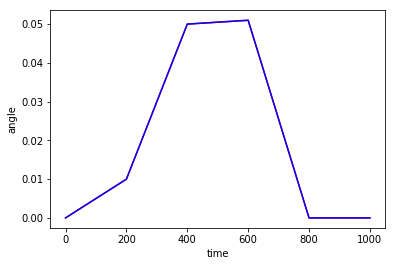

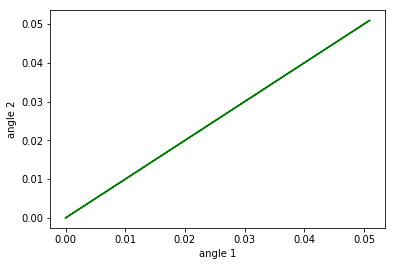

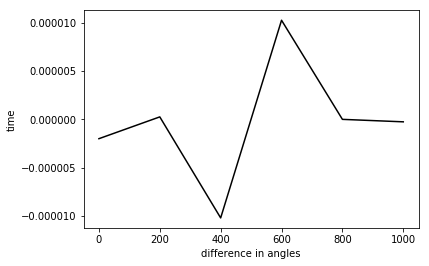

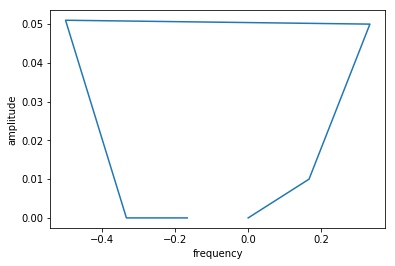

In [3]:
plt.plot(t, theta_1, 'r', t, theta_2, 'b')
plt.xlabel('time')
plt.ylabel('angle')
plt.show()

plt.plot(theta_1, theta_2, 'g')
plt.xlabel('angle 1')
plt.ylabel('angle 2')
plt.show()

theta_diff = map(operator.sub, theta_1, theta_2)

plt.plot(t, theta_diff, 'k')
plt.ylabel('time')
plt.xlabel('difference in angles')
plt.show()

freq_theta_1 = np.fft.fft(theta_1)
freq = np.fft.fftfreq(t.shape[-1])

plt.plot(freq, freq_theta_1.real)
plt.ylabel('amplitude')
plt.xlabel('frequency')
plt.show()